<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [399]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind_from_stats, pearsonr
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re

In [400]:
# get files, clean them up
def clean_files(df, control):
    file = pd.read_csv(df, index_col = 0)
    file.index = file.index.str.strip()
    if not (control):
        file = file[["2017", "2018", "2019", "2020", "2021"]]
    return file
    
violent_crime = clean_files("data_files/violent_crime_rates.csv", control=False)
property_crime = clean_files("data_files/property_crime_rates.csv", control=False)
unemployment = clean_files("data_files/unemployment.csv", control=False)
health_factors = clean_files("data_files/health_factors.csv", control=False)
health_outcomes = clean_files("data_files/health_outcomes.csv", control=False)
od_deaths = clean_files("data_files/od_death_rate_final.csv", control=False)
free_reduced_meals = clean_files("data_files/free_reduced_meals.csv", control=False)
graduation_rates = clean_files("data_files/graduation_rates.csv", control=False)
population = clean_files("data_files/population.csv", control=False)
wealth_metrics = clean_files("data_files/wealth_metrics.csv", control=True)
urban_rural = clean_files("data_files/urban_rural.csv", control=True)
political_affiliation = clean_files("data_files/political_affiliation.csv", control=True)

In [401]:
# remove commas from data
def remove_commas(string):
    return re.sub(",", "", string)

for col in population.columns:
    population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
    
# remove percentage signs from data
def remove_percentage(string):
    return re.sub("%", "", string)

for col in free_reduced_meals.columns:
    free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)
    
def remove_dollar(string):
    return re.sub("\$", "", string)

for col in wealth_metrics.columns:
    wealth_metrics.loc[:,col] = wealth_metrics[col].astype(str).apply(remove_dollar)
    wealth_metrics.loc[:,col] = wealth_metrics[col].astype(str).apply(remove_commas)
    

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_39372/3877520494.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_39372/3877520494.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)


In [402]:
def res_to_df(res):
    """
    Transform the result of an statsmodels results table to
    a pandas dataframe"""
    pvals = res.pvalues
    coeff = res.params
    conf_lower = res.conf_int()[0]
    conf_higher = res.conf_int()[1]
    df = pd.DataFrame(
        {
            "pvals": pvals,
            "coeff": coeff,
            "conf_lower": conf_lower,
            "conf_higher": conf_higher,
        }
    )
    cols = ["coeff", "pvals", "conf_lower", "conf_higher"]
    df = df[cols]
    df.reset_index(inplace=True)
    df.columns = ["name"] + cols
    return df

In [403]:
# convert crime rates from numbers to per capita
violent_crime.astype(int)
per_capita_crime = violent_crime / population

property_crime.astype(int)
per_capita_property_crime = property_crime / population

urban_rural.columns = ['total_units', 'urban_units', 'rural_units']

urban_rural.urban_units = urban_rural.urban_units / urban_rural.total_units
urban_rural.rural_units = urban_rural.rural_units / urban_rural.total_units


In [404]:
wealth_metrics.columns = ['population', 'population_density', 'per_capita_income', 'median_household_income', 'median_family_income']
median_household_income = wealth_metrics.drop(['population', 'population_density', 'per_capita_income', 'median_family_income'], axis=1)
percent_urban = urban_rural.drop(['total_units', 'rural_units'], axis=1)

republican = political_affiliation.drop(["District Attorney (2022)", "Attorney General (2022)", "AG % Margin of Victory (2022)"], axis=1)


In [405]:
# unstack all the dataframes and rename their columns
population_all = population.unstack().reset_index()
per_capita_violent_all = per_capita_crime.unstack().reset_index()
per_capita_property_all = per_capita_property_crime.unstack().reset_index()
unemployment_all = unemployment.unstack().reset_index()
health_factors_all = health_factors.unstack().reset_index()
health_outcomes_all = health_outcomes.unstack().reset_index()
od_deaths_all = od_deaths.unstack().reset_index()
free_reduced_meals_all = free_reduced_meals.unstack().reset_index()
graduation_rates_all = graduation_rates.unstack().reset_index()

population_all.columns = ['year', 'county', 'population']
per_capita_violent_all.columns = ['year', 'county', 'violent_crime_rate']
per_capita_property_all.columns = ['year', 'county', 'property_crime_rate']
unemployment_all.columns = ['year', 'county', 'unemployment']
health_factors_all.columns = ['year', 'county', 'health_factors']
health_outcomes_all.columns = ['year', 'county', 'health_outcomes']
od_deaths_all.columns = ['year', 'county', 'od_deaths']
free_reduced_meals_all.columns = ['year', 'county', 'free_reduced_meals']
graduation_rates_all.columns = ['year', 'county', 'graduation_rate']

def combine_dfs(df_list):
    main_df = per_capita_violent_all
    for df in df_list:
        main_df = pd.merge(main_df, df)
    return main_df

clean_data = combine_dfs([population_all, per_capita_property_all, unemployment_all, health_factors_all, 
                          health_outcomes_all, od_deaths_all, graduation_rates_all, free_reduced_meals_all])


In [406]:
def plot_rates(x, y, title, xlabel, ylabel):
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [407]:
clean_data["median_household_income"] = clean_data.county.map(median_household_income.iloc[:,0])
clean_data["percent_urban"] = clean_data.county.map(percent_urban.iloc[:,0])
clean_data["republican"] = clean_data.county.map(republican.iloc[:,0])

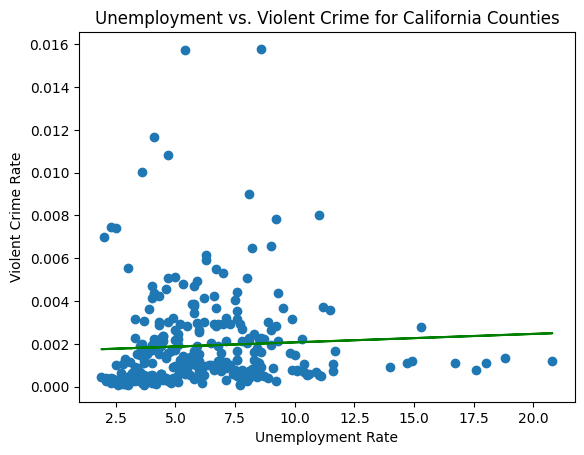

In [425]:
plot_rates(clean_data.unemployment, clean_data.violent_crime_rate, 
           "Unemployment vs. Violent Crime for California Counties",
          "Unemployment Rate", "Violent Crime Rate")

a, b = np.polyfit(clean_data.unemployment, clean_data.violent_crime_rate, 1)
plt.plot(clean_data.unemployment, a * clean_data.unemployment + b, color="g")

In [409]:
# plot_rates(clean_data.graduation_rate, clean_data.property_crime_rate, 
#            "Graduation Rate vs. Property Crime for California Counties",
#           "Graduation Rate", "Property Crime Rate")

In [410]:
clean_data.median_household_income = clean_data.median_household_income.astype(float)

In [411]:
fit = smf.ols(
    "violent_crime_rate ~ 1 + population + republican + unemployment + health_factors + median_household_income + health_outcomes + od_deaths + graduation_rate + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")
res = res_to_df(fit).set_index("name")

In [412]:
# residualize data for income
income_effect = pd.DataFrame()

fit_income_a = smf.ols(
    "violent_crime_rate ~ 1 + population + republican + unemployment + health_factors + health_outcomes + od_deaths + graduation_rate + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

fit_income_b = smf.ols(
    "median_household_income ~ 1 + population + republican + unemployment + health_factors + health_outcomes + od_deaths + graduation_rate + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

income_effect["crime_residuals"] = (clean_data.violent_crime_rate - fit_income_a.predict(clean_data))
income_effect["income_residuals"] = (clean_data.median_household_income - fit_income_b.predict(clean_data))

# just to check that coefficients are the same as without doing the residuals
fit_income_c = smf.ols(
    "crime_residuals ~ income_residuals",
    income_effect,
).fit(cov_type="HC1")
res_income_c = res_to_df(fit_income_c).set_index("name")

# take the difference between 10th and 90th percentile, multiply it by coefficient
stats = income_effect.describe([0.1,0.9])
x = res["coeff"].loc["median_household_income"] * (stats.income_residuals.loc['90%'] - stats.income_residuals.loc['10%'])

# percent of violent_crime difference attributed to income
x / clean_data.violent_crime_rate.mean()

# plot residuals
# plt.scatter(income_effect.income_residuals, income_effect.crime_residuals)

0.3182727188304117

In [413]:
# residualize data for graduation rate
grad_rate_effect = pd.DataFrame()

fit_grad_a = smf.ols(
    "violent_crime_rate ~ 1 + population + republican + median_household_income + unemployment + health_factors + health_outcomes + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

fit_grad_b = smf.ols(
    "graduation_rate ~ 1 + population + republican + median_household_income + unemployment + health_factors + health_outcomes + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

grad_rate_effect["crime_residuals"] = (clean_data.violent_crime_rate - fit_grad_a.predict(clean_data))
grad_rate_effect["grad_residuals"] = (clean_data.graduation_rate - fit_grad_b.predict(clean_data))

# take the difference between 10th and 90th percentile, multiply it by coefficient
stats = grad_rate_effect.describe([0.1,0.9])
y = res["coeff"].loc["graduation_rate"] * (stats.grad_residuals.loc['90%'] - stats.grad_residuals.loc['10%'])

# percent of violent_crime difference attributed to grad rate
y / clean_data.violent_crime_rate.mean()


-0.3427602833816752

In [414]:
# residualize data for health outcomes
health_outcomes_effect = pd.DataFrame()

fit_health_a = smf.ols(
    "violent_crime_rate ~ 1 + population + republican + median_household_income + graduation_rate + unemployment + health_factors + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

fit_health_b = smf.ols(
    "health_outcomes ~ 1 + population + republican + median_household_income + unemployment + health_factors + graduation_rate + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

health_outcomes_effect["crime_residuals"] = (clean_data.violent_crime_rate - fit_health_a.predict(clean_data))
health_outcomes_effect["ho_residuals"] = (clean_data.health_outcomes - fit_health_b.predict(clean_data))

# take the difference between 10th and 90th percentile, multiply it by coefficient
stats = health_outcomes_effect.describe([0.1,0.9])
z = res["coeff"].loc["health_outcomes"] * (stats.ho_residuals.loc['90%'] - stats.ho_residuals.loc['10%'])

# percent of violent_crime difference attributed to health outcomes
z / clean_data.violent_crime_rate.mean()


0.3746082735216589

In [417]:
# residualize data for unemployment
unemployment_effect = pd.DataFrame()

fit_unemployment_a = smf.ols(
    "violent_crime_rate ~ 1 + population + republican + median_household_income + graduation_rate + health_outcomes + health_factors + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

fit_unemployment_b = smf.ols(
    "unemployment ~ 1 + population + republican + median_household_income + health_outcomes + health_factors + graduation_rate + od_deaths + free_reduced_meals + percent_urban + C(year)",
    clean_data,
).fit(cov_type="HC1")

unemployment_effect["crime_residuals"] = (clean_data.violent_crime_rate - fit_unemployment_a.predict(clean_data))
unemployment_effect["unemployment_residuals"] = (clean_data.unemployment - fit_unemployment_b.predict(clean_data))

# take the difference between 10th and 90th percentile, multiply it by coefficient
stats = unemployment_effect.describe([0.1,0.9])
a = res["coeff"].loc["unemployment"] * (stats.unemployment_residuals.loc['90%'] - stats.unemployment_residuals.loc['10%'])

# percent of violent_crime difference attributed to unemployment
a / clean_data.violent_crime_rate.mean()

0.11084392108752454

In [364]:
# not necessary anymore, now that we're using residuals
res["magnitude"] = abs(res["coeff"]) * clean_data.mean()

stats_og = clean_data.describe([0.1,0.9])
res["coeff"] * (stats_og.loc['90%'] - stats_og.loc['10%'])

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_39372/1212826683.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  res["magnitude"] = abs(res["coeff"]) * clean_data.mean()
